<a href="https://www.kaggle.com/code/jameswerther/the-art-of-the-run?scriptVersionId=127083266" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
import bq_helper
# Any results you write to the current directory are saved as output.

[]


### The following notebook attempts to quantify "The Run" in college basketball, which for those unfamiliar is an extended scoring streak by one team over some period of time. The notebook culminates with a visual display of how often teams go on runs versus their ability to prevent them, along with some pretty interesting relationships with the 2017 NCAA Tournament. Enjoy!

# Play-by-play data collection

In [2]:
# create a helper object for this dataset
bq = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                              dataset_name="ncaa_basketball")
bq.list_tables()

Using Kaggle's public dataset BigQuery integration.


['mascots',
 'mbb_games_sr',
 'mbb_historical_teams_games',
 'mbb_historical_teams_seasons',
 'mbb_historical_tournament_games',
 'mbb_pbp_sr',
 'mbb_players_games_sr',
 'mbb_teams',
 'mbb_teams_games_sr',
 'team_colors']

In [3]:
#Rows per season
query1 = "SELECT season, COUNT(*) from `bigquery-public-data.ncaa_basketball.mbb_pbp_sr` GROUP BY season"
seasons = bq.query_to_pandas_safe(query1, max_gb_scanned=1)
print(seasons)

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


   season     f0_
0    2017  915589
1    2015  961955
2    2016  808550
3    2014  837937
4    2013  636362


In [4]:
#pull 2017 season scoring data
query2017 = "SELECT home_name, home_id, away_name, away_id, game_id, elapsed_time_sec, shot_made, points_scored, team_id, team_name from `bigquery-public-data.ncaa_basketball.mbb_pbp_sr` WHERE season = 2017 AND shot_made = True"
df_2017 = bq.query_to_pandas_safe(query2017, max_gb_scanned=4)
print(df_2017)

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


       home_name                               home_id away_name  \
0       Wildcats  4383eb6a-7fd8-4ff2-94c5-43c933121e88  Jayhawks   
1       Wildcats  4383eb6a-7fd8-4ff2-94c5-43c933121e88  Jayhawks   
2       Wildcats  4383eb6a-7fd8-4ff2-94c5-43c933121e88  Jayhawks   
3       Wildcats  4383eb6a-7fd8-4ff2-94c5-43c933121e88  Jayhawks   
4       Wildcats  4383eb6a-7fd8-4ff2-94c5-43c933121e88  Jayhawks   
...          ...                                   ...       ...   
177196  Redhawks  7e100f63-0b32-49f6-a954-f5b7c8cf48ad  Vaqueros   
177197   Cowboys  8ab00d43-840a-4c96-bdee-bf88fa6e3f11  Vaqueros   
177198   Cowboys  8ab00d43-840a-4c96-bdee-bf88fa6e3f11  Vaqueros   
177199   Cowboys  8ab00d43-840a-4c96-bdee-bf88fa6e3f11  Vaqueros   
177200   Cowboys  8ab00d43-840a-4c96-bdee-bf88fa6e3f11  Vaqueros   

                                     away_id  \
0       fae4855b-1b64-4b40-a632-9ed345e1e952   
1       fae4855b-1b64-4b40-a632-9ed345e1e952   
2       fae4855b-1b64-4b40-a632-9ed345e

In [5]:
#formulate list of individual games and teams
df_2017_games = df_2017['game_id']
df_2017_teams = df_2017[['team_id', 'team_name']]
df_2017_games = df_2017_games.drop_duplicates()
df_2017_teams = df_2017_teams.drop_duplicates()
df_2017_teams = df_2017_teams.values.tolist()
print(len(df_2017_games), len(df_2017_teams))
print(df_2017_teams[0])

2235 361
['fae4855b-1b64-4b40-a632-9ed345e1e952', 'Jayhawks']


In [6]:
#create dict structure {team id: [name, # of games, runs completed, runs conceded]}
team_rpg = {team[0]: [team[1],0,0,0]  for team in df_2017_teams}

# Calculating the run

In [7]:
def analyze_game(game_id):
    #dataframe of the play-by-play for a given game
    gamequery = f"SELECT home_name, home_id, away_name, away_id, game_id, elapsed_time_sec, shot_made, points_scored, team_id from `bigquery-public-data.ncaa_basketball.mbb_pbp_sr` WHERE season = 2017 AND shot_made = True AND game_id = '{game_id}'"
    df_game = bq.query_to_pandas_safe(gamequery, max_gb_scanned=4)
    df_game = df_game.groupby(['game_id']).apply(lambda x: x.sort_values('elapsed_time_sec'))
    
    #identify teams, establish point_differential column
    homeid = df_game.iloc[0].home_id
    team_rpg[homeid][1] += 1
    awayid = df_game.iloc[0].away_id
    team_rpg[awayid][1] += 1
    homename = df_game.iloc[0].home_name
    awayname = df_game.iloc[0].away_name
    df_game['point_differential'] = 0

    #calculate current point differential during game
    pdiff = 0
    for index, row in df_game.iterrows():
        if row.team_id == homeid:
            pdiff += row.points_scored
        else:
            pdiff -= row.points_scored
        df_game.at[index, 'point_differential'] = pdiff
        
    
    #sliding window approach to calculate runs
    #a run is defined as a gain of at least 10 in point differential over a 3 minute span
    window_size = 180
    step_size = 1
    last_run = None

    interval_data = pd.DataFrame(columns=['start_time', 'end_time', 'point_differential'])

    # iterate over all possible 3min windows
    for start_time in df_game['elapsed_time_sec']:
        end_time = start_time + window_size

        # filter for the rows within the current window
        window = df_game[(df_game['elapsed_time_sec'] >= start_time) & (df_game['elapsed_time_sec'] < end_time)]

        # calculate the point differential at the start and end of the window
        start_diff = window.iloc[0]['point_differential']
        end_diff = window.iloc[-1]['point_differential']
        run_size = end_diff - start_diff

        # check if the point differential is 10 or more
        #prevent overlap by making sure the current run is sufficiently spaced from the last
        if abs(run_size) >= 10 and (last_run is None or abs(start_time - last_run) > 180):
            team = ""
            if run_size < 0:
                team_name = awayname
                team_rpg[awayid][2] += 1
                team_rpg[homeid][3] += 1
            else:
                team_name = homename
                team_rpg[homeid][2] += 1
                team_rpg[awayid][3] += 1
                

            interval_data = interval_data.append({
                'team_name': team_name,
                'start_time': start_time/60,
                'end_time': end_time/60,
                'point_differential': abs(run_size)
            }, ignore_index=True)
            last_run = start_time


    #for _, row in interval_data.iterrows():
        #print(f"{row['team_name']} run from {row['start_time']} to {row['end_time']} with a point differential of {row['point_differential']}")


# 2017 season analysis

In [8]:
#analyze individual games, (took about an hour to run so I needed the log statements to be somewhat verbose for status reasons)
for row in df_2017_games.iteritems():
    analyze_game(row[1])
#print(team_rpg)

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


# Cleaning, organizing dataframes

In [9]:
#now calculate runs and runs conceded on a per game basis
final_team_runs_pg = {
    team: {
    'team_name': team_rpg[team][0],
    'games_played': team_rpg[team][1],
    'runs_per_game': float(int(team_rpg[team][2])/int(team_rpg[team][1])),
    'runs_against_per_game': float(int(team_rpg[team][3])/int(team_rpg[team][1]))} for team in team_rpg
}

df_runs = pd.DataFrame.from_dict(final_team_runs_pg)
df_runs_transposed = df_runs.transpose()
print(df_runs_transposed.head(5))
df_runs_transposed.to_csv('runinfo.csv')

                                       team_name games_played runs_per_game  \
fae4855b-1b64-4b40-a632-9ed345e1e952    Jayhawks           39      0.487179   
bdc2561d-f603-4fab-a262-f1d2af462277  Wolverines           39      0.487179   
4383eb6a-7fd8-4ff2-94c5-43c933121e88    Wildcats           40           0.5   
61a3908a-7492-4b6f-809e-12c61976bb0a    Ramblers           22      0.227273   
10f450ce-143b-4e46-8bfe-52c644b68b07  Mean Green            8           0.0   

                                     runs_against_per_game  
fae4855b-1b64-4b40-a632-9ed345e1e952              0.179487  
bdc2561d-f603-4fab-a262-f1d2af462277              0.025641  
4383eb6a-7fd8-4ff2-94c5-43c933121e88                 0.075  
61a3908a-7492-4b6f-809e-12c61976bb0a              0.090909  
10f450ce-143b-4e46-8bfe-52c644b68b07                 0.125  


In [10]:
df_runs_sorted = df_runs_transposed.sort_values('runs_per_game', ascending=False)
df_runs_sorted = df_runs_sorted[df_runs_sorted.games_played >= 10]
print(df_runs_sorted.head(5))
print('------------------------------------------------------------------')
df_against_sorted = df_runs_transposed.sort_values('runs_against_per_game', ascending=False)
df_against_sorted = df_against_sorted[df_against_sorted.games_played >= 10]
print(df_against_sorted.head(5))

                                        team_name games_played runs_per_game  \
faeb1160-5d15-4f26-99fc-c441cf21fc7f  Blue Devils           37      0.675676   
ad4bc983-8d2e-4e6f-a8f9-80840a786c64   Sun Devils           27       0.62963   
f38b58de-3273-4723-a78b-2f918e9aa2d5     Shockers           33      0.606061   
7d797407-623e-476d-b299-46de4275414d     Bluejays           33      0.606061   
ec0d6b67-4b16-4b50-92b2-1a651dae6b0f       Bruins           33      0.545455   

                                     runs_against_per_game  
faeb1160-5d15-4f26-99fc-c441cf21fc7f              0.189189  
ad4bc983-8d2e-4e6f-a8f9-80840a786c64              0.222222  
f38b58de-3273-4723-a78b-2f918e9aa2d5              0.181818  
7d797407-623e-476d-b299-46de4275414d              0.212121  
ec0d6b67-4b16-4b50-92b2-1a651dae6b0f              0.272727  
------------------------------------------------------------------
                                        team_name games_played runs_per_game  \
eb157f

In [11]:
df_runs_sorted.to_csv('runs_sorted.csv')

# Graphics Data for Visual

In [12]:
#get logos for each team to create infographic, export rankings to csv
def fetchlogo(teamid):
    logoquery = f"SELECT logo_small from `bigquery-public-data.ncaa_basketball.mbb_teams` WHERE id = '{teamid}'"
    logo = bq.query_to_pandas_safe(logoquery, max_gb_scanned=1)
    return logo['logo_small'][0]
    
df_runs_sorted['logo'] = 'a'
for idx, row in df_runs_sorted.iterrows():
    df_runs_sorted.at[idx, 'logo'] = fetchlogo(idx)
    
print(df_runs_sorted.head(5))

#request library is acting out with kaggle notebook, creating matplotlib visual locally, contact if you would like to see the code

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


                                        team_name games_played runs_per_game  \
faeb1160-5d15-4f26-99fc-c441cf21fc7f  Blue Devils           37      0.675676   
ad4bc983-8d2e-4e6f-a8f9-80840a786c64   Sun Devils           27       0.62963   
f38b58de-3273-4723-a78b-2f918e9aa2d5     Shockers           33      0.606061   
7d797407-623e-476d-b299-46de4275414d     Bluejays           33      0.606061   
ec0d6b67-4b16-4b50-92b2-1a651dae6b0f       Bruins           33      0.545455   

                                     runs_against_per_game  \
faeb1160-5d15-4f26-99fc-c441cf21fc7f              0.189189   
ad4bc983-8d2e-4e6f-a8f9-80840a786c64              0.222222   
f38b58de-3273-4723-a78b-2f918e9aa2d5              0.181818   
7d797407-623e-476d-b299-46de4275414d              0.212121   
ec0d6b67-4b16-4b50-92b2-1a651dae6b0f              0.272727   

                                                                                   logo  
faeb1160-5d15-4f26-99fc-c441cf21fc7f  https://www.ncaa.c

In [13]:
df_runs_sorted.to_csv('runs_with_logos.csv')

## And with a bit of matplotlib, we get this...

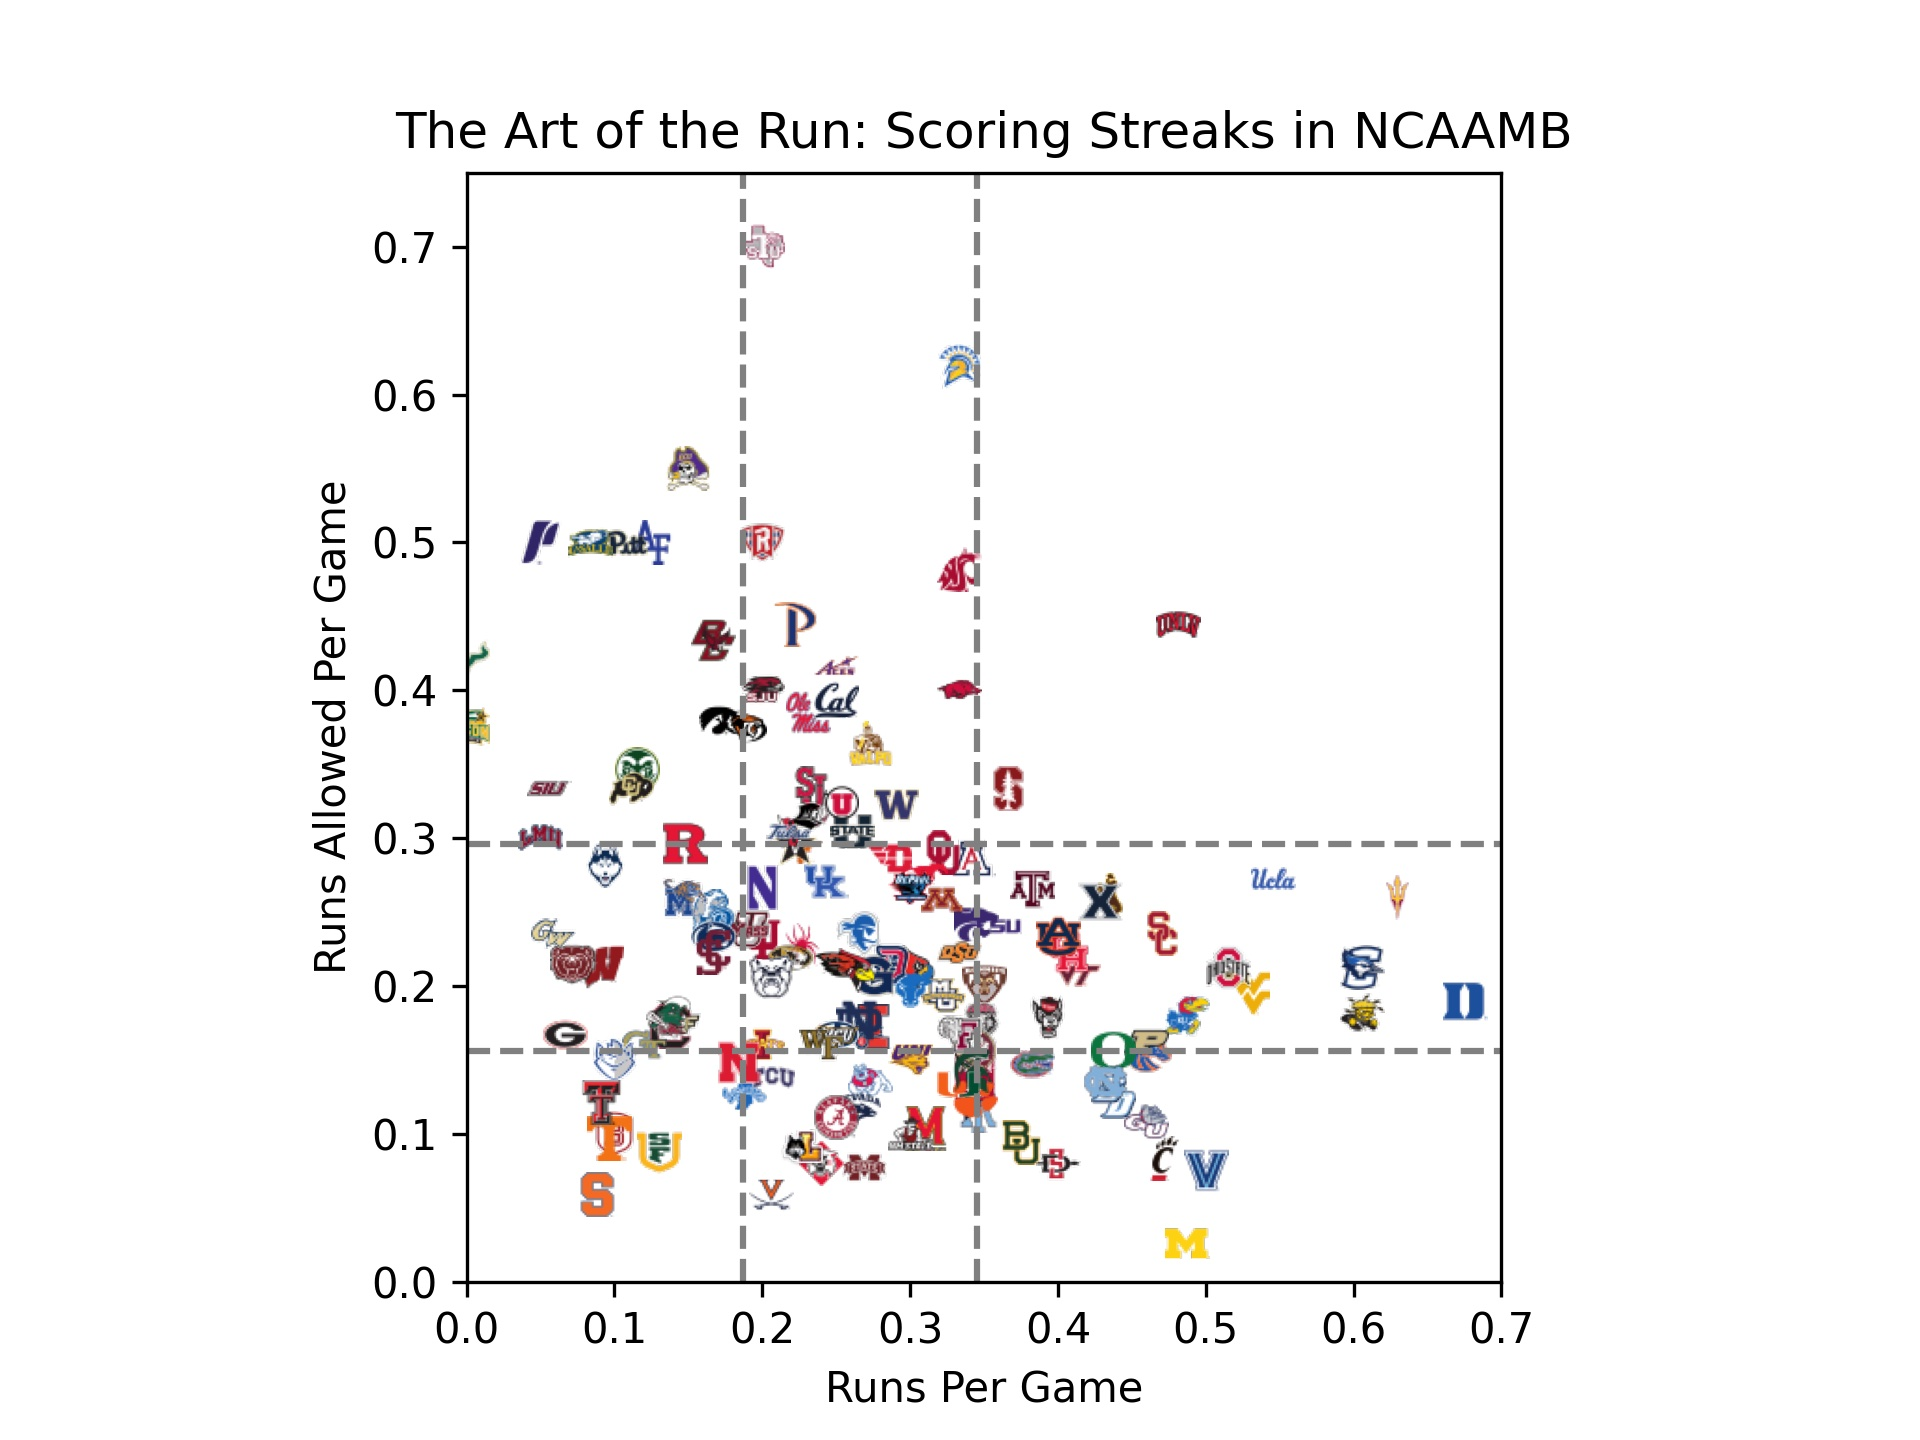

# Let's talk about it


<div>
As a lifelong college basketball fan, I'm quite familiar with the concept of March being a 'game of runs.' My question was whether or not that's actually true. Calculating runs from scratch is a pain for a lot of reasons. First of all, what is a run? For the purposes of this investigation, I classified a run as a gain in 10+ point differential over a three minute span. I'm sure many of you will throw your arms up at that value, but it's what I picked. 10 is large, but it packs a punch, and I wanted to quantify those killer scoring streaks that really put a game away. I've seen a few similar investigations in the past that only count consecutive points scored as runs, and I felt like that missed out on a ton of significant stretches (like a 12-2 run with a meaningless layup in the middle by the losing team). Anyway, that's only the beginning of the trouble. Next, you need to organize every point scored for each game in a time series, and for my solution I used a sliding window to capture the timeframes that fit this definition of a run. After over an hour of bigquery doing its magic, thanks surely in part to my subpar querying skills, I was left with a pretty sporadic set of results. Play-by-play data is hard to come by, and in this case it was missing a ton of games. As a bare minimum, I dropped every team with less than 10 games from the dataset, however most had upwards of 30 (especially power 5 and mid-majors). My final dataframe had runs per game and runs allowed per game for each team. Then with some nifty matplotlib work, I used the urls in the team table to swap normal scatterplot points with logos.
</div>
<br>
<div>
So how did a team's tendency to go on and prevent runs affect the 2017 basketball season? The dividing lines were set along the 25th and 75th percentile for each axis, so the bottom right represents 75th+ percentile for runs gained and 25th+ for runs conceded, etc. While using tournament performance is clearly a less reliable comparator as any sort of regression model, it's fun to look back and see if this was truly the bracket crystal ball people were looking for.
</div>
<br>
<div>
Starting with the top left, not a single team up here made the tournament, and for good reason. There's not much to say here other than the fact that none of these teams could stop a run or go on one for themselves. Moving right, the success rates stay pretty stagnant, with our only tournament "win" coming from a first four victory out of Texas Southern, who were promptly destroyed in the round of 64. In the 'chaos' quadrant, those who could not stop a run for their lives but could return the favor, only two teams fit the bill: UNLV and Stanford. Neither of whom had any tournament success either, although UNLV had a 20-13 regular season and a slight conference tournament run.
</div>
<br>
<div>
The middle row gets interesting now that the teams that could put together runs were strong enough defensively to put a stop to their opponents. While the left-middle sector once again did absolutely nothing, middle-middle and right-middle give us our first contenders. Florida State ~barely~ sneaks into the middle sector as the first elite eight survivor so far, with a fantastic run as a 9-seed. It's worth noting for later on that they are about as close to both the 25th percentile for runs against and 75th for runs for as you can get. In the middle-right, things get weird. UCLA was the fifth-most prolific run producer in college basketball, and failed to make it out of the first four. Wichita State, the fourth highest, was on the rough side of a 13-4 upset. Creighton and Arizona state, numbers three and two lost in the first round and missed the tournament, respectively. Only Duke, the runniest of the runners, was able to survive the sweet sixteen before being sent home by Kansas. So if we can pin one trend on the middle-right sector, it would probably be inflated value.
</div>
<br>
<div>
This brings us to the bottom row and our conclusion for the 2017 NCAA Men's basketball season: going on runs wins games, stopping the run wins championships. Three of the four Final Four teams fell below the 25th percentile for runs allowed per game, and five of the eight Elite Eight (if you count FSU straddling the line) fit the bill as well. Many of the tournament's biggest Cinderella's hid down here. Loyola-Chicago, perhaps the story of decade, sat bottom-middle, with Syracuse pulling off an 11-seeded Sweet Sixteen run out of the bottom-left sector. The bottom-right, as expected, was absolutely dominant. Both finals participants, Nova and Michigan, were tucked in the bottom right. Now, the bottom row was still home to plenty of disappointment, as second-seeded Cincinnati lost to seventh-seeded Nevada in the round of 32, North Carolina got smoked in the round of 32 as a two-seed, and Florida met a similar fate.
</div>
<br>
<div>
I'm excited to put together a few models with this data and try to draw some real correlation with these rates instead of just speculating on tournament results. I'd also love to eventually gather data from other seasons, but for the time being I'm more than pleased with how this turned out. Smack in the bottom right we have our two finalists, and Cinderella's are littered throughout the bottom row. As a coach, I don't know how you tell your team to stop the run, but as a Bracketologist, keep a keen eye out for those run-resistant defenses this March.
</div>

# Episode 2: 2023 Data is Here!

<div>
    

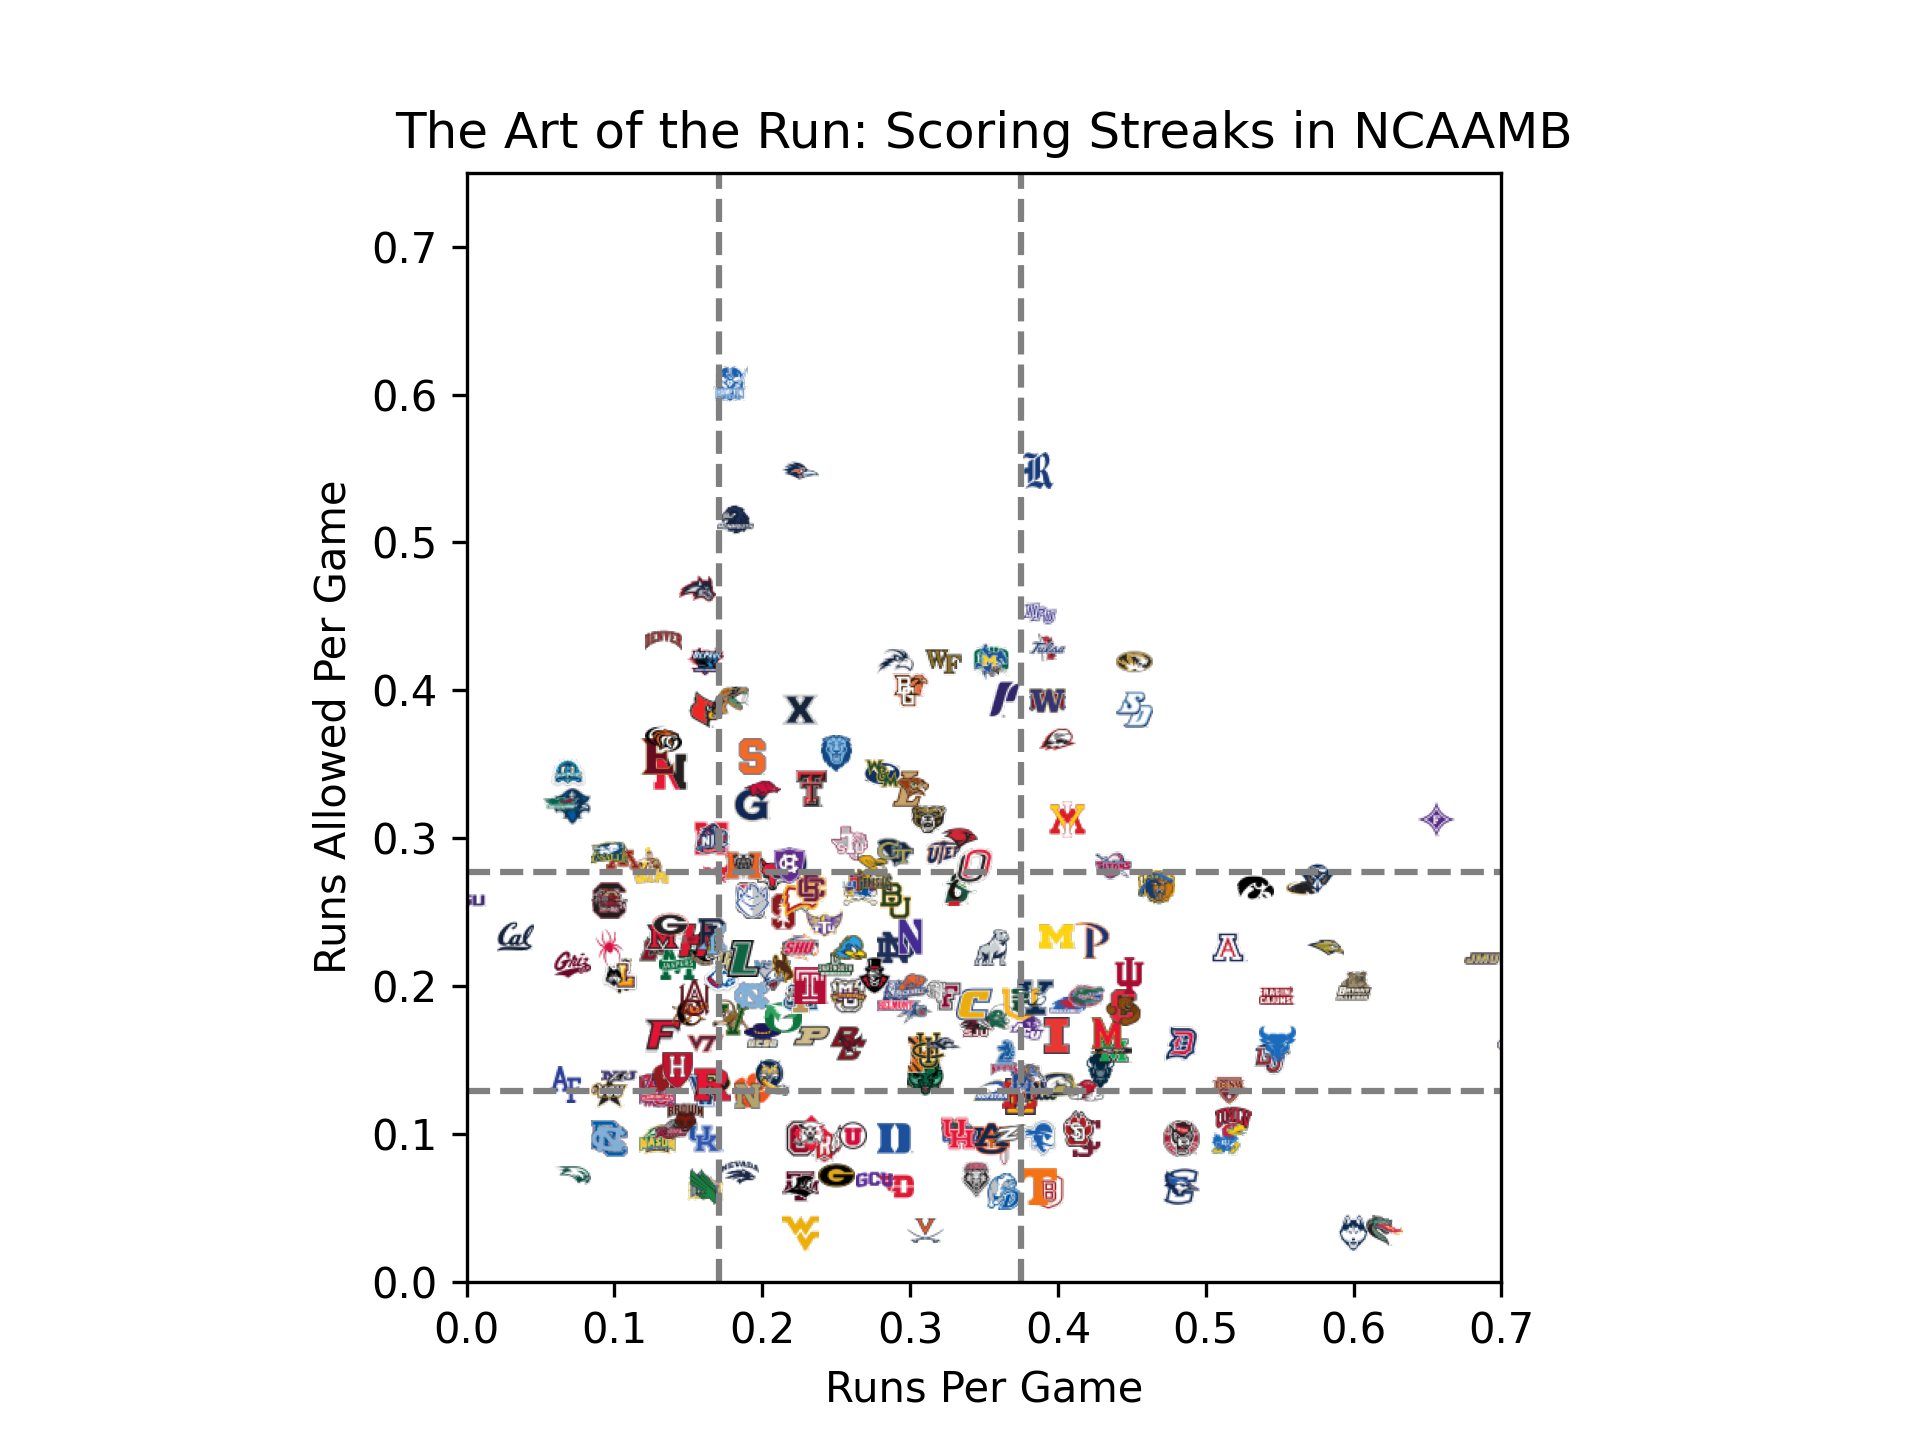

<div>
    2023 was a pretty cool success. With the first year of current data, we got some very intriguing results. Straight off the bat, we can see our 2023 tournament champions, UCONN, performed the best. For 2023, I had to use the RHoops package to obtain play-by-play data, and ended up missing a few teams. The database schema also did not match up like the bigquery table for 2017, so retrieving image data was more difficult, but we'll dig into it.
<br>
<br>
    My hypothesis from the previous iteration was that being in the lower third was far more important than being to the right. For the most part, this held up. In the 'quadrant of disappointment' from last time, the right middle, we have some serious underachievers. This includes Arizona, Michigan, and depending on how you view Oral Roberts' first round exit, you could argue the Golden Eagles.
 <br>
 <br>
    In the upper third, nobody even sniffed success in the tournament. Xavier, one of the only teams to make it from all the way up there, made it to the Sweet 16 but were promptly blown out by Texas. Texas Southern, another team to sneak in, were obliterated by Cinderella story FDU. Lastly, we have Furman in the 'chaos zone.' And they delivered exactly that. A game full of runs on both ends with Virginia resulted in one of the upsets of March. Way to go Paladins.
<br>
<br>
    Other than the disappointments from earlier, there's not much to talk about in the middle, so let's look at the bottom. In the bottom third we have the NIT runner-up and champion: UAB and North Texas. Now, let's break down the Final Four. San Diego State was missing a logo image so they are not on the graph, but they would have been in the middle-middle square. Miami is also missing a logo, but they came in at a staggering (0.66, 0.1), which places them square in the bottom-right. FAU scored (0.48, 0.09), which also earns a bottom-right appearance. With UCONN being clear in the corner, this gives us 75% of the Final Four in the bottom right quadrant! Pretty cool stuff. Other bottom-right teams include Creighton in the Elite 8, and I'm going to shoutout NC State who fell to Creighton in the first round despite putting up one heck of a fight through star Sophomore guard Terquavion Smith. I'll try to fill in the images when I can, but what a year for the Art of the Run!